In [1]:
import sys

base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

In [2]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from math import sqrt
from pydmd import DMD
from statsmodels.tsa.arima.model import ARIMA

from src.filler import RandomForestFillerWithOneModel, LstmFillerModel, HodmdFiller
from statsmodels.tsa.seasonal import seasonal_decompose
import copy

In [4]:
def introduce_gaps(data, missing_percentage=0.2, random_seed=42):
    np.random.seed(random_seed)
    data_with_gaps = data.copy()

    for column in data.columns:
        num_missing = int(missing_percentage * len(data))
        missing_indices = np.random.choice(data.index, size=num_missing, replace=False)
        data_with_gaps.loc[missing_indices, column] = np.nan

    return data_with_gaps

def introduce_long_gaps(data, missing_percentage=0.1, random_seed=42, min_gap_size=5, max_gap_size=20):
    np.random.seed(random_seed)
    data_with_gaps = data.copy()

    for column in data.columns:
        num_missing = int(missing_percentage * len(data))
        missing_indices = np.random.choice(len(data), size=num_missing, replace=False)

        for idx in missing_indices:
            gap_size = np.random.randint(min_gap_size, max_gap_size)
            data_with_gaps[column].iloc[(int)(idx):(int)(idx+gap_size)] = pd.NA

    return data_with_gaps

def find_largest_complete_interval_final(data):
    complete_rows = data.notna().all(axis=1).astype(int)

    diff = complete_rows.diff()
    diff.iloc[0] = complete_rows.iloc[0]

    starts = diff[diff == 1].index.values[:-1]
    ends = diff[diff == -1].index.values

    if len(starts) > len(ends):
        ends = np.append(ends, complete_rows.index[-1])

    lengths = ends - starts
    max_length_index = lengths.argmax()

    return starts[max_length_index], ends[max_length_index] - 1, lengths[max_length_index]

def extract_largest_complete_interval(data):
    start, end, _ = find_largest_complete_interval_final(data)
    return data.loc[start:end]

In [5]:
def blockwise_tdem(series, alpha=0.01):
    filled_series = series.copy()
    n = len(series)

    max_gap = n
    weights = np.exp(-alpha * np.arange(max_gap))

    is_nan = np.isnan(series)
    diff = np.diff(is_nan.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    if is_nan[0]:
        starts = np.insert(starts, 0, 0)

    if is_nan[-1]:
        ends = np.append(ends, n)

    for start, end in zip(starts, ends):
        valid_weights = weights[:start][::-1]
        observed_values = series[:start]

        non_na_indices = ~np.isnan(observed_values)
        numerator = np.sum(valid_weights[non_na_indices] * observed_values[non_na_indices])
        denominator = np.sum(valid_weights[non_na_indices])

        filled_series[start:end] = numerator / (denominator + 1e-10)
    return filled_series

def interpolation(data, method='linear', limit_direction='backward'):
    return data.interpolate(method = method, limit_direction = limit_direction)

def knn(data):
    k = 5
    imputer = KNNImputer(n_neighbors=k)
    filled_data_knn_sklearn = imputer.fit_transform(data)

    return pd.DataFrame(filled_data_knn_sklearn, columns=data.columns, index=data.index)


def svm_imputation_single_column(data, target_column):
    imputed_data = data.copy()

    train_data = data.dropna(subset=[target_column])

    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]

    test_data = data[data[target_column].isna()]
    X_test = test_data.drop(columns=[target_column])

    model = make_pipeline(SimpleImputer(strategy='mean'),
                          StandardScaler(),
                          SVR(C=1.0, epsilon=0.2))

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    imputed_data.loc[imputed_data[target_column].isna(), target_column] = y_pred

    return imputed_data

def pca_imputation(data, max_iter=20, tol=1e-5):
    imputed_data = data.fillna(data.mean())

    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(imputed_data)

    prev_data = copy.deepcopy(data_normalized)

    for i in range(max_iter):
        pca = PCA(n_components=data.shape[1])
        pca.fit(data_normalized)

        reconstructed = pca.inverse_transform(pca.transform(data_normalized))

        mask_missing = data.isna().values
        data_normalized[mask_missing] = reconstructed[mask_missing]

        change = np.sqrt(((data_normalized - prev_data) ** 2).sum())
        if change < tol:
            break

        prev_data = copy.deepcopy(data_normalized)

    imputed_data_final = scaler.inverse_transform(data_normalized)
    return pd.DataFrame(imputed_data_final, columns=data.columns, index=data.index)

def mice(data):
    mice_imputer = IterativeImputer(max_iter=30, random_state=62)
    filled_data_mice = mice_imputer.fit_transform(data)
    return pd.DataFrame(filled_data_mice, columns=data.columns, index=data.index)


def impute_with_random_forest(data, target_column):
    known = data[data[target_column].notna()]
    unknown = data[data[target_column].isna()]

    X_known = known.drop(columns=[target_column])
    y_known = known[target_column]
    X_unknown = unknown.drop(columns=[target_column])

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
    rf.fit(X_known, y_known)

    y_pred = rf.predict(X_unknown)

    data.loc[data[target_column].isna(), target_column] = y_pred

    return data

def soft_impute(data, max_iter=50, tol=1e-6):
    filled_data = data.fillna(data.mean())
    filled_data_prev = filled_data.copy()

    mask = data.notna()

    for i in range(max_iter):
        U, sigma, Vt = np.linalg.svd(filled_data, full_matrices=False)
        reconstructed = pd.DataFrame(np.dot(U, np.dot(np.diag(sigma), Vt)), index=data.index, columns=data.columns)
        filled_data = data.where(mask, other=reconstructed)
        diff = np.linalg.norm(filled_data_prev - filled_data)
        if diff < tol:
            break

        filled_data_prev = filled_data.copy()
    return filled_data


def dmd_impute(data):
    filled_data = data.copy()
    matrix_data = filled_data.copy().values.T

    col_mean = np.nanmean(matrix_data, axis=1)
    inds_nan = np.where(np.isnan(matrix_data))
    matrix_data[inds_nan] = np.take(col_mean, inds_nan[0])

    dmd = DMD(svd_rank=matrix_data.shape[0])
    dmd.fit(matrix_data)
    dmd_data = dmd.reconstructed_data.real.T
    filled_data.values[np.isnan(data.values)] = dmd_data[np.isnan(data.values)]

    return filled_data

def arima_impute(df, order=(2,0,0)):
    df.loc[(data_with_gaps.index < data_with_gaps.first_valid_index()), "RADIATION"] = df["RADIATION"].mean()
    values = df.values
    data_filled = []

    for v in values:
        if pd.isna(v):
            model_arima = ARIMA(data_filled, order=order)
            model_fit = model_arima.fit()
            output = model_fit.forecast()
            pred = output[0]
            data_filled.append(pred)
        else:
            data_filled.append(v[0])

    return  pd.DataFrame(data_filled, columns=df.columns, index=df.index)


In [6]:
class Debbuger:
    @staticmethod
    def log(is_debug, *values: object):
        if is_debug:
            print(values)

class RandomForestFiller:
    model: RandomForestRegressor
    n_in: int = 5
    n_out: int = 1
    is_debug: bool = False

    def __init__(self, n_estimators):
        self.n_estimators = n_estimators

    def windowing(self, values, step_back, step_front):
        x, y = [], []
        for i in range(len(values) - step_back - step_front + 1):
            j = (i + step_back)
            x.append(values[i:j])
            y.append(values[j:(j+step_front)])
        return np.array(x), np.array(y)

    def train_test_split(self, data, n_test):
        return data[:-n_test, :], data[-n_test:, :]

    def train(self, history):
        Debbuger.log(self.is_debug, 'History:',history)
        self.model = RandomForestRegressor(n_estimators=self.n_estimators)
        trainX, trainY = self.windowing(values=history, step_back=self.n_in, step_front=self.n_out)
        Debbuger.log(self.is_debug, 'Train Data:',trainX, trainY)
        self.model.fit(trainX, trainY.ravel())
        

    def fill(self, history, retrain):
        if retrain:
            self.n_in = min((len(history)-self.n_out), 5)
            self.train(history=history)
        
        xhat = [history[-self.n_in:]]
        Debbuger.log(self.is_debug, 'xhat', xhat)
        yhat = self.model.predict(xhat)[0]
        Debbuger.log(self.is_debug, 'Predict value:', yhat)
        return yhat

def update_history(history):
    length = min(50, len(history))
    return history[-length:]

def filler(dataserie: pd.Series, filler: RandomForestFiller):
    dataserie_filled = dataserie.copy()

    history = []

    filling = False
    init_idx = None

    for i, r in enumerate(dataserie_filled):
        if pd.isna(r) or r is None:
            history = update_history(history)
            
            new_value = filler.fill(history, retrain=filling is False) 

            dataserie_filled.iloc[i] = new_value
            history.append(new_value)

            if filling:
                print('completando...')
            else:
                print('começando a completar...')
                filling = True
        else:
            history.append(r)
            if filling:
                print('lacuna completada!')
                filling = False
    return dataserie_filled



In [7]:
def rf_filler(df):
    filler = RandomForestFillerWithOneModel(n_estimators=1000, n_in=10, n_out=1)
    data = {}
    for column in df.columns:
        data[column] = filler.filler(df[column])
    return pd.DataFrame(data=data, index=df.index.values)

def lstm_filler(df):
    filler = LstmFillerModel(n_in=5, n_out=1)
    data = {}
    for column in df.columns:
        data[column] = filler.filler(df[column])
    return pd.DataFrame(data=data, index=df.index.values)

In [8]:
def seasonal_filler(df, period=365, factor=1):
    data = df.copy()
    data['RADIATION_temp'] = data['RADIATION']
    data['RADIATION_temp'].fillna(method='ffill', inplace=True)
    data['RADIATION_temp'].fillna(method='bfill', inplace=True)

    decomposition = seasonal_decompose(data['RADIATION_temp'], period=period, model='additive', extrapolate_trend='freq')

    seasonal_component = decomposition.seasonal
    seasonal_component = abs(seasonal_component * factor)

    data['RADIATION_interp'] = data['RADIATION']
    data['RADIATION_interp'].loc[data['RADIATION'].isna()] = seasonal_component.loc[data['RADIATION'].isna()]
    data['RADIATION'] = data['RADIATION_interp']

    data.drop('RADIATION_temp', axis=1, inplace=True)
    data.drop('RADIATION_interp', axis=1, inplace=True)

    return data

In [9]:
def show_result(name, original_data, filled_data):
    print('\n' + name)
    show_error_metrics(original_data, filled_data)

def show_error_metrics(real, pred):
    print(real.shape, pred.shape)
    r2 = r2_score(real, pred)
    mse = mean_squared_error(real, pred)
    rmse = sqrt(mean_squared_error(real, pred))
    mae = mean_absolute_error(real, pred)
    mape = mean_absolute_percentage_error(real, pred)

    print('Test R2: %.3f' % abs(r2))
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: %.3f' % mae)
    print('Test MAPE: %.3f' % mape)

In [10]:
filename = f'{base_path}/data/daily_barbacena.csv'

df = pd.read_csv(
    filename,
    sep=',',
    parse_dates=['Timestamp'],
    index_col=['Timestamp'])

df = df[['RADIATION']] \
    .resample('D') \
    .agg({'RADIATION': np.sum})\
    .replace(0, np.nan)

data = extract_largest_complete_interval(df)
print('Dados faltantes', data.isna().sum())
print('Total de dados', len(data))
data

Dados faltantes RADIATION    0
dtype: int64
Total de dados 3127


/var/folders/tf/7zgm_5115vjc9x3162_qjg140000gn/T/ipykernel_9761/4178547331.py:9: FutureWarning: The provided callable <function sum at 0x1057faee0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df[['RADIATION']] \


,RADIATION
Timestamp,
2012-10-18,9250.9
2012-10-19,19953.4
2012-10-20,23155.9
2012-10-21,21307.6
2012-10-22,19533.1
...,...
2021-05-06,14216.4
2021-05-07,15078.7
2021-05-08,7538.6


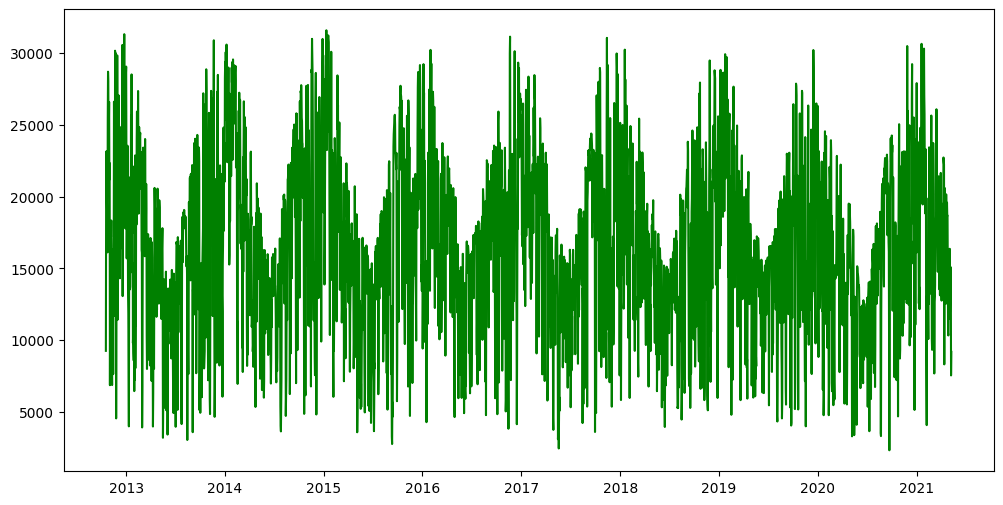

In [11]:
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[0:-1], color='green', label='interpolation')
pyplot.show()

RADIATION    0
dtype: int64
RADIATION    790
dtype: int64


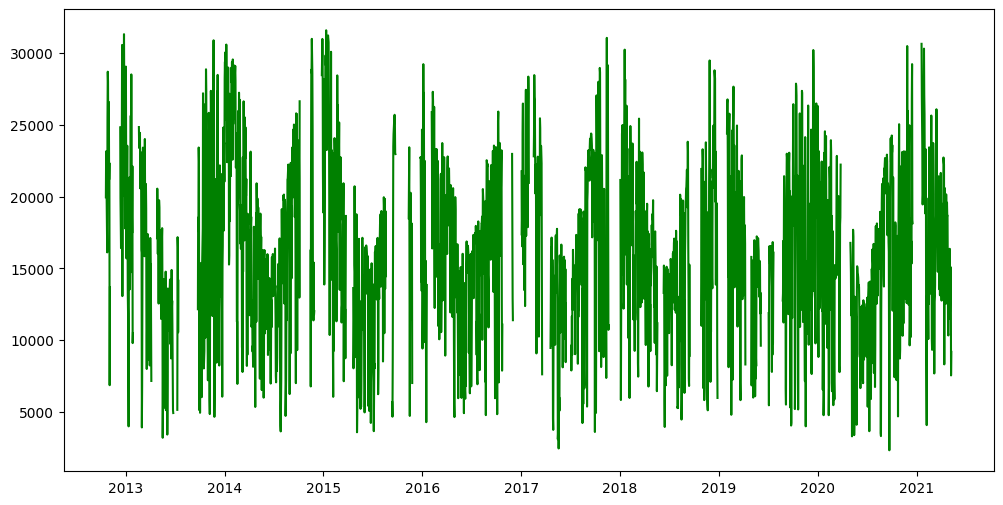

In [12]:
data_with_gaps = introduce_long_gaps(data, missing_percentage=0.01, min_gap_size=10, max_gap_size=45)

print(data.isna().sum())
print(data_with_gaps.isna().sum())

data_with_gaps = data_with_gaps[1:]
data = data[1:]

pyplot.figure(figsize=(12, 6))
pyplot.plot(data_with_gaps.copy()[0:-1], color='green', label='interpolation')
pyplot.show()

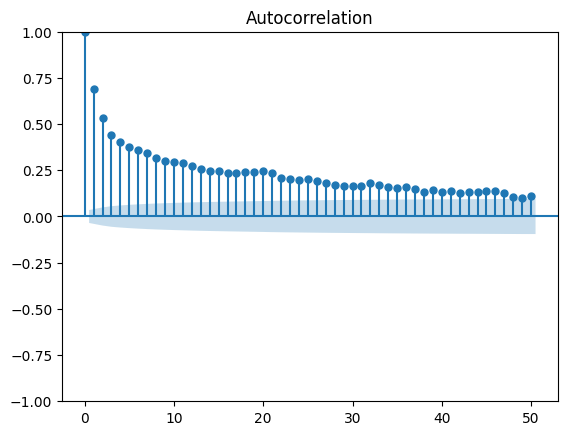

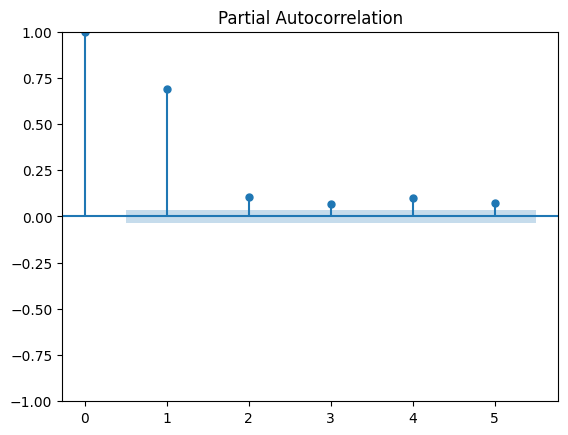

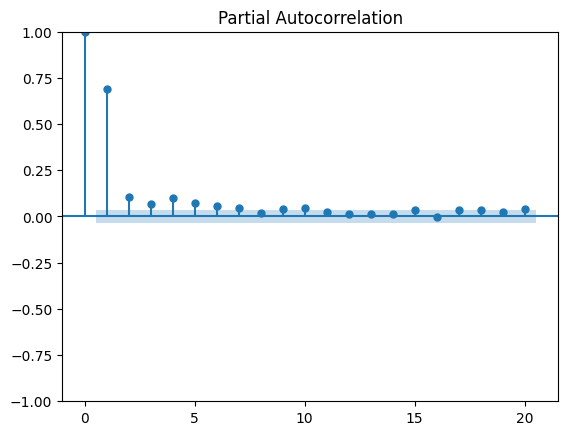

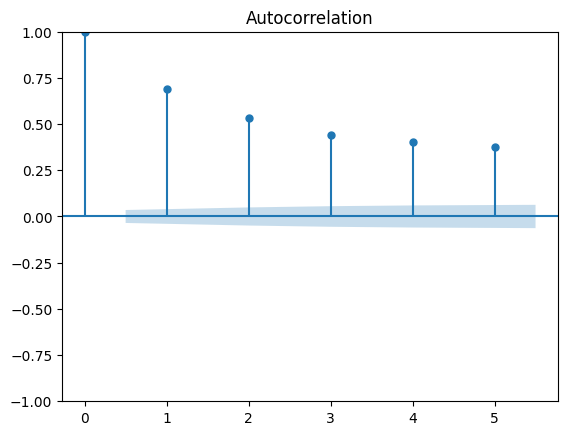

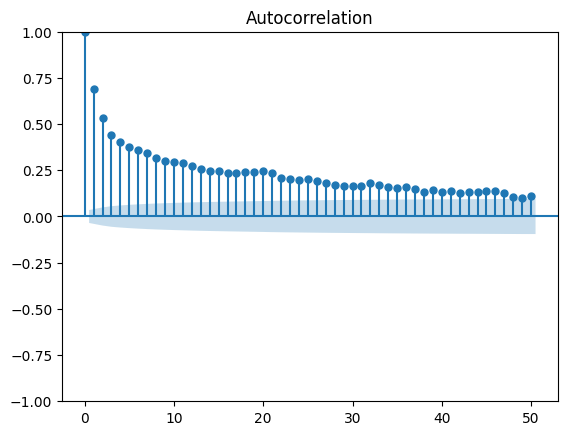

In [13]:
data_temp = interpolation(data_with_gaps)

plot_pacf(data_temp, lags=5, method="ywm")
plot_pacf(data_temp, lags=20, method="ywm")

plot_acf(data_temp, lags=5)
plot_acf(data_temp, lags=50)

#plt.show()

In [15]:
filled_data_pca = pca_imputation(data_with_gaps.copy())
#filled_data_svm_radiation = svm_imputation_single_column(data_with_gaps.copy(), "RADIATION")
filled_data_interpolation = interpolation(data_with_gaps.copy())
filled_data_time_interpolation = data_with_gaps.interpolate(method='time')
filled_data_polyn_interpolation = data_with_gaps.interpolate(method='polynomial', order=3)
filled_data_spline_interpolation = data_with_gaps.interpolate(method='spline', order=3)
filled_data_knn = knn(data_with_gaps.copy())
filled_data_mice = mice(data_with_gaps.copy())
filled_data_rf = rf_filler(data_with_gaps)
filled_data_svd = soft_impute(data_with_gaps.copy())
filled_data_dmd2 = dmd_impute(data_with_gaps.copy())
filled_data_arima = arima_impute(data_with_gaps.copy())
#filled_data_lstm = lstm_filler(data_with_gaps.copy())
filled_data_seasonal_interp = seasonal_filler(data_with_gaps.copy(), period=365, factor=5)

/var/folders/tf/7zgm_5115vjc9x3162_qjg140000gn/T/ipykernel_9761/68209970.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['RADIATION_temp'].fillna(method='ffill', inplace=True)
/var/folders/tf/7zgm_5115vjc9x3162_qjg140000gn/T/ipykernel_9761/68209970.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['RADIATION_temp'].fillna(method='bfill', inplace=True)
/Users/yuri/sdk/miniforge3/envs/tf/lib/python3.9/site-packages/pydmd/hodmd.py:140: UserWarning: The parameter 'svd_rank_extra=0' has been ignored because the given system is a scalar function
  warnings.warn(


(3126, 1)


In [20]:
filled_data_hodmd = HodmdFiller(d_factor=0.8).dmd_filler(data_with_gaps.RADIATION.copy())

(3126, 1)


/Users/yuri/sdk/miniforge3/envs/tf/lib/python3.9/site-packages/pydmd/hodmd.py:140: UserWarning: The parameter 'svd_rank_extra=0' has been ignored because the given system is a scalar function
  warnings.warn(


In [16]:
print(len(data_with_gaps))
print(data_with_gaps.isna().sum())

3126
RADIATION    790
dtype: int64


In [21]:
show_all = True
if show_all:
    print('\nPCA')
    show_error_metrics(data, filled_data_pca)
    show_result('Interpolation Linear', data, interpolation(data_with_gaps.copy(), 'linear'))

    print('\nInterpolation Time')
    show_error_metrics(data, filled_data_mice)

    print('\nInterpolation Polynomial')
    show_error_metrics(data, filled_data_polyn_interpolation)

    print('\nInterpolation Spline')
    show_error_metrics(data, filled_data_spline_interpolation)

    print('\nMICE')
    show_error_metrics(data, filled_data_mice)
    print('\nRF')
    show_error_metrics(data, filled_data_rf)
    print('\nSVD')
    show_error_metrics(data, filled_data_svd)
    print('\nDMD')
    show_error_metrics(data, filled_data_dmd2)
    print('\nKNN')
    show_error_metrics(data, filled_data_knn)
    #print('\nLSTM')
    #show_error_metrics(data, filled_data_lstm)
    print('\nSeasonal Interpolate')
    show_error_metrics(data, filled_data_seasonal_interp)
    print('\nHODMD')
    show_error_metrics(data, filled_data_hodmd)



PCA
(3126, 1) (3126, 1)
Test R2: 0.732
Test MSE: 9519260.860
Test RMSE: 3085.330
Test MAE: 1267.810
Test MAPE: 0.100

Interpolation Linear
(3126, 1) (3126, 1)
Test R2: 0.697
Test MSE: 10732145.550
Test RMSE: 3275.995
Test MAE: 1333.036
Test MAPE: 0.099

Interpolation Time
(3126, 1) (3126, 1)
Test R2: 0.732
Test MSE: 9519260.860
Test RMSE: 3085.330
Test MAE: 1267.810
Test MAPE: 0.100

Interpolation Polynomial
(3126, 1) (3126, 1)
Test R2: 11.858
Test MSE: 456105487.734
Test RMSE: 21356.626
Test MAE: 7145.470
Test MAPE: 0.509

Interpolation Spline
(3126, 1) (3126, 1)
Test R2: 11.857
Test MSE: 456079945.994
Test RMSE: 21356.028
Test MAE: 7145.350
Test MAPE: 0.509

MICE
(3126, 1) (3126, 1)
Test R2: 0.732
Test MSE: 9519260.860
Test RMSE: 3085.330
Test MAE: 1267.810
Test MAPE: 0.100

RF
(3126, 1) (3126, 1)
Test R2: 0.606
Test MSE: 13969481.175
Test RMSE: 3737.577
Test MAE: 1520.216
Test MAPE: 0.097

SVD
(3126, 1) (3126, 1)
Test R2: 0.732
Test MSE: 9519260.860
Test RMSE: 3085.330
Test MAE: 12

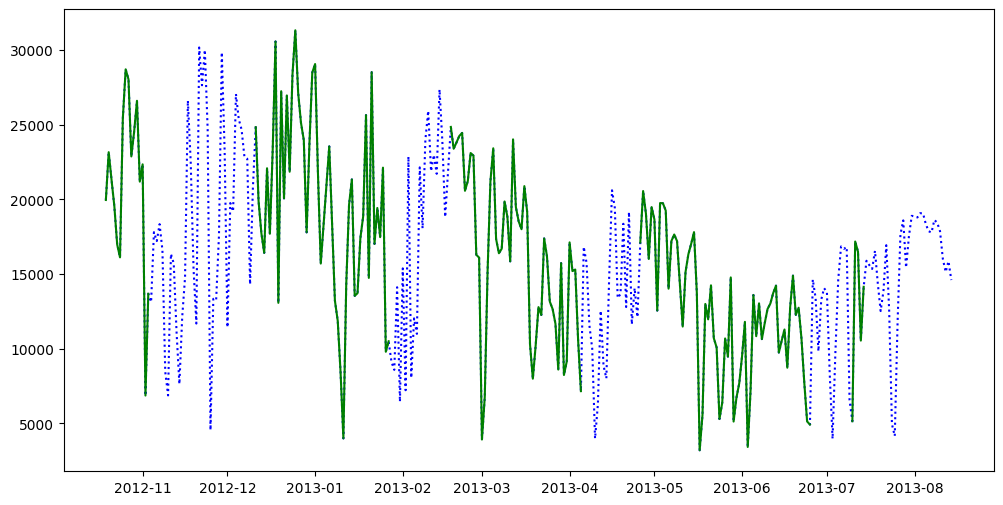

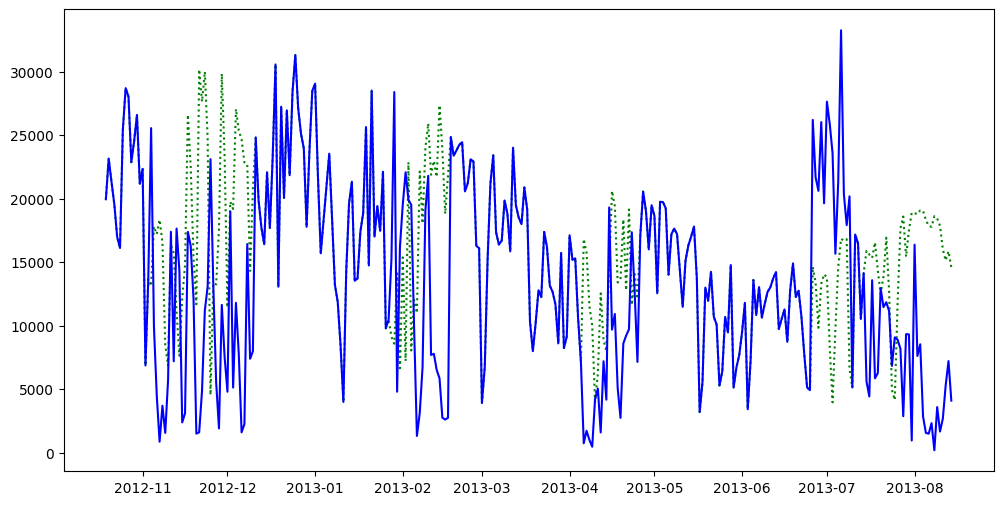

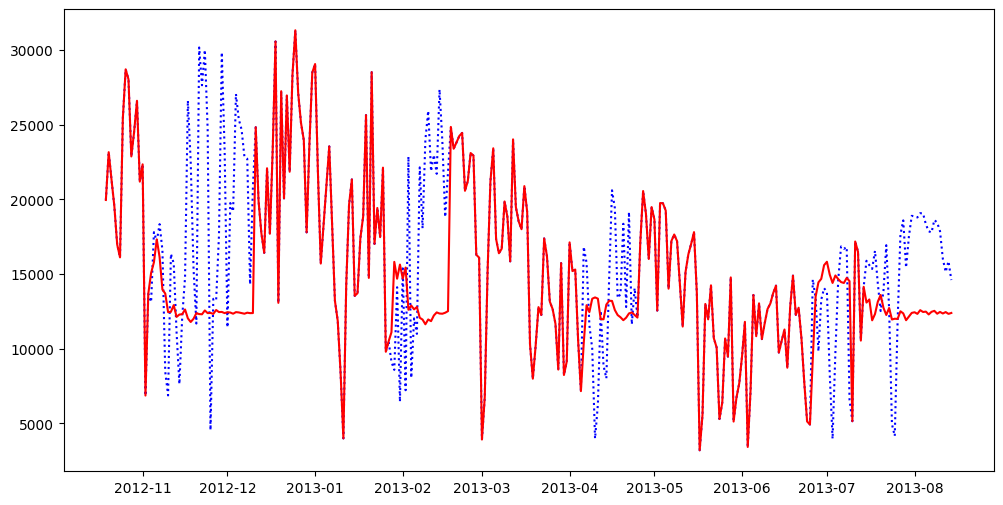

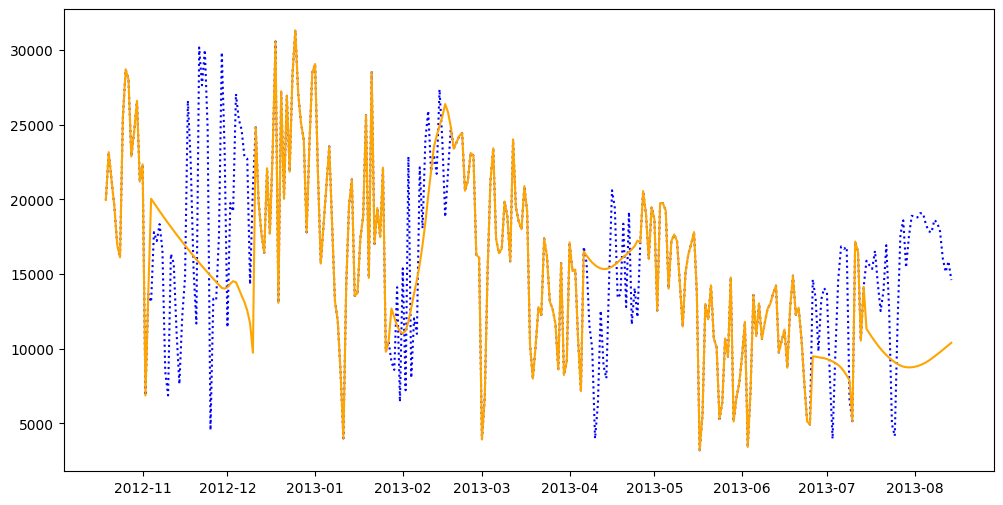

In [22]:
maxrange = 300


pyplot.figure(figsize=(12, 6))
pyplot.plot(data[0:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_with_gaps[0:maxrange], color='green', label='missing_data')
pyplot.show()

pyplot.figure(figsize=(12, 6))
pyplot.plot(data[0:maxrange], color = 'g', linestyle = ':')
pyplot.plot(filled_data_seasonal_interp[0:maxrange], color='blue', label='interpolation seasonal')
pyplot.show()

pyplot.figure(figsize=(12, 6))
pyplot.plot(data[0:maxrange], color = 'b', linestyle = ':')
pyplot.plot(filled_data_rf[0:maxrange], color='red', label='rf')
pyplot.show()

pyplot.figure(figsize=(12, 6))
pyplot.plot(data[0:maxrange], color = 'b', linestyle = ':')
pyplot.plot(filled_data_hodmd[0:maxrange], color='orange', label='knn')
pyplot.show()